This file contains python code to test HDF logi  

It is under the logi setting

Now, I use the same beta and X is raw MEG

In [1]:
import sys
sys.path.append("../../mypkg")

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from easydict import EasyDict as edict
from tqdm import trange, tqdm
from pprint import pprint
import itertools
from scipy.stats import chi2


In [3]:
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

In [4]:
from constants import DATA_ROOT, RES_ROOT, FIG_ROOT, MIDRES_ROOT
from hdf_utils.data_gen import gen_simu_meg_dataset
from hdf_utils.SIS import SIS_GLIM
from utils.matrix import col_vec_fn, col_vec2mat_fn, conju_grad, svd_inverse, cholesky_inv
from utils.functions import logit_fn
from utils.misc import save_pkl, load_pkl
from splines import obt_bsp_obasis_Rfn, obt_bsp_basis_Rfn_wrapper
from projection import euclidean_proj_l1ball
from optimization.opt import HDFOpt
from scenarios.real_simu_logi_meg import settings
from hdf_utils.fns_sinica import  fourier_basis_fn

from joblib import Parallel, delayed

In [5]:
plt.style.use(FIG_ROOT/"base.mplstyle")
torch.set_default_tensor_type(torch.DoubleTensor)

In [6]:
AD_ts = load_pkl(DATA_ROOT/"AD_vs_Ctrl_ts/AD88_all.pkl")
Ctrl_ts = load_pkl(DATA_ROOT/"AD_vs_Ctrl_ts/Ctrl92_all.pkl")
ts_data = np.concatenate([AD_ts, Ctrl_ts], axis=0)
stds = ts_data.std(axis=(1, 2));
ts_data_filter = ts_data[np.sort(np.where(stds>100)[0])];

Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_real/../../mypkg/../data/AD_vs_Ctrl_ts/AD88_all.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_real/../../mypkg/../data/AD_vs_Ctrl_ts/Ctrl92_all.pkl


In [7]:
np.random.seed(0)
c = 0.0

setting = settings.nm1
data_gen_params = setting.data_gen_params
data_gen_params.cs = data_gen_params.cs_fn(c)
data_gen_params.gt_beta = data_gen_params.beta_fn(data_gen_params.cs)
#data_gen_params.gt_beta = np.zeros_like(data_gen_params.beta_fn(data_gen_params.cs))

N = 10
obt_bsp = obt_bsp_obasis_Rfn
basis_mat = obt_bsp(np.linspace(0, 1, data_gen_params.npts), N, 4)
gt_gam = np.zeros((N, 68));
gt_gam[:, -1] = np.linspace(0, 1, N) * (-1)**np.arange(N)
#data_gen_params.gt_beta = basis_mat @ gt_gam;

num_rep = 200
Cmat = np.eye(data_gen_params.d - len(setting.sel_idx))
save_dir = RES_ROOT/f"simu_logi_setting{setting.setting}_test"
if not save_dir.exists():
    save_dir.mkdir()
Cmat

R[write to console]: 
Attaching package: ‘orthogonalsplinebasis’


R[write to console]: The following object is masked from ‘package:stats’:

    integrate




array([[1.]])

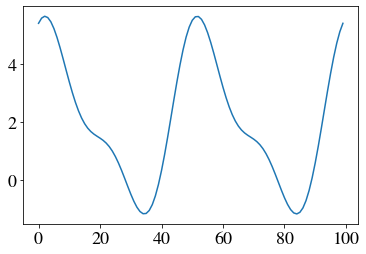

In [8]:
plt.plot(data_gen_params.gt_beta[:, -1])

In [9]:
data_gen_params.gt_alp = np.array([-0.64, -1, 2])

In [10]:
def _run_fn(seed, lam, N, n, setting, inits=None, is_save=False, is_cv=False, verbose=2):
    """Now (on Aug 25, 2023), if we keep seed the same, the cur_data is the same. 
       If you want to make any changes, make sure this. 
    """
    torch.set_default_dtype(torch.double)
    np.random.seed(seed)
    torch.manual_seed(seed)
        
    _setting = edict(setting.copy())
    _setting.seed = seed
    _setting.lam = lam
    _setting.N = N
    
    data_gen_params = setting.data_gen_params
    
    f_name = f"seed_{seed:.0f}-lam_{lam*1000:.0f}-N_{N:.0f}_fit.pkl"
    
    
    if not (save_dir/f_name).exists():
        cur_data = gen_simu_meg_dataset(n=n, 
                                   q=data_gen_params.q, 
                                   types_=data_gen_params.types_, 
                                   gt_alp=data_gen_params.gt_alp, 
                                   gt_beta=data_gen_params.gt_beta, 
                                   npts=data_gen_params.npts, 
                                   base_data=ts_data_filter, 
                                   data_type=data_gen_params.data_type,
                                   data_params=data_gen_params.data_params, 
                                   seed=seed, 
                                   verbose=verbose);
        hdf_fit = HDFOpt(lam=_setting.lam, 
                         sel_idx=_setting.sel_idx, 
                         model_type=_setting.model_type,
                         verbose=verbose, 
                         SIS_ratio=_setting.SIS_ratio, 
                         N=_setting.N,
                         is_std_data=True, 
                         cov_types=None, 
                         inits=inits,
                         model_params = _setting.model_params, 
                         SIS_params = _setting.SIS_params, 
                         opt_params = _setting.opt_params,
                         bsp_params = _setting.bsp_params, 
                         pen_params = _setting.pen_params
               );
        hdf_fit.add_data(cur_data.X, cur_data.Y, cur_data.Z)
        opt_res = hdf_fit.fit()
        
        if is_cv:
            hdf_fit.get_cv_est(_setting.num_cv_fold)
        if is_save:
            hdf_fit.save(save_dir/f_name, is_compact=False, is_force=True)
    else:
        hdf_fit = load_pkl(save_dir/f_name, verbose>=2);
        
    return hdf_fit


# single test

In [35]:
setting.opt_params.is_BFGS = "adaptive" 
#setting.opt_params.N_eps = 1e-5
#setting.opt_params.stop_cv = 5e-4
#setting.opt_params.beta = 1
#setting.opt_params.R = 3000000
#setting.bsp_params.is_orth_basis = True
data_gen_params.gt_alp = np.array([-0.64, -1, 2])
#data_gen_params.types_ = ["int", "c", "c"]

In [36]:
seed = 0
lam = 0.1
N = 6

obt_bsp = obt_bsp_obasis_Rfn
basis_mat = torch.tensor(obt_bsp(np.linspace(0, 1, data_gen_params.npts), N, 4)).to(torch.get_default_dtype())
Gam_init = torch.tensor(np.linalg.inv(basis_mat.numpy().T  
                                      @ basis_mat.numpy())  
                        @ basis_mat.numpy().T  
                        @ data_gen_params.gt_beta)
alp_init = torch.tensor(data_gen_params.gt_alp)
rhok_init = torch.zeros(N*data_gen_params.d);
inits = [Gam_init, alp_init, rhok_init];

In [37]:

res = _run_fn(seed=seed, lam=lam, N=N, n=2000, setting=setting, inits=None, is_cv=False, is_save=False, verbose=2)

2024-02-09 11:21:12,965 - optimization.opt - INFO - opt parmas is {'stop_cv': 0.0005, 'max_iter': 2000, 'one_step_verbose': 0, 'alpha': 0.9, 'beta': 1.0, 'R': 200000.0, 'N_eps': 0.0001, 'N_maxit': 100, 'is_BFGS': 'adaptive'}.
2024-02-09 11:21:12,966 - optimization.opt - INFO - SIS parmas is {'SIS_pen': 5, 'SIS_basis_N': 10, 'SIS_basis_ord': 4, 'SIS_ratio': 0.2}.
2024-02-09 11:21:12,967 - optimization.opt - INFO - model parmas is {}.
2024-02-09 11:21:12,967 - optimization.opt - INFO - penalty parmas is {'a': 3.7, 'lam': 0.1}.
2024-02-09 11:21:12,968 - optimization.opt - INFO - bspline parmas is {'basis_ord': 4, 'is_orth_basis': True, 'N': 6}.
2024-02-09 11:21:12,968 - optimization.opt - INFO - As cov_types is not provided, inferring the continuous covariates.
Main Loop:  12%|██████████▌                                                                             | 239/2000 [00:09<01:12, 24.39it/s, error=0.000568, GamL0=3, CV=0.0005]


In [38]:
res.est_alp

tensor([-0.4285, -0.6816,  1.5296])

# Multipe test

In [30]:
#setting.opt_params.is_BFGS = "adaptive" 
#setting.opt_params.N_eps = 1e-5
#setting.opt_params.stop_cv = 5e-4
data_gen_params.gt_alp = np.array([-0.64, -1, 2])

In [34]:
_err_fn = lambda est_alp: np.linalg.norm(setting.data_gen_params.gt_alp0 - est_alp[1:])
ns = [100, 200, 400, 800, 1600, 3200]
N = 6
lam = 0.1
num_rep = 20

def _run_fn1(seed, n):
    torch.set_default_dtype(torch.double)
    obt_bsp = obt_bsp_obasis_Rfn
    basis_mat = torch.tensor(obt_bsp(np.linspace(0, 1, data_gen_params.npts), N, 4)).to(torch.get_default_dtype())
    Gam_init = torch.tensor(np.linalg.inv(basis_mat.numpy().T  
                                          @ basis_mat.numpy())  
                            @ basis_mat.numpy().T  
                            @ data_gen_params.gt_beta)
    alp_init = torch.tensor(data_gen_params.gt_alp)
    rhok_init = torch.zeros(N*data_gen_params.d);
    inits = [Gam_init, alp_init, rhok_init];
    res = _run_fn(seed=seed, lam=lam, N=N, n=n, setting=setting, inits=None, is_cv=False, verbose=1)
    return res
    
    
est_alps = []
for n in ns:
    with Parallel(n_jobs=20) as parallel:
        test_ress = parallel(delayed(_run_fn1)(seed, n=n) for seed in tqdm(range(num_rep), total=num_rep, desc=f"n: {n}"))
    est_alps.append([res.est_alp.numpy() for res in test_ress])
    

n: 100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 42.28it/s]
Process LokyProcess-13:
Process LokyProcess-10:
Process LokyProcess-3:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 620, in __call__
    return self.func(*args, **kwargs)
  File "/opt/conda/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 620, in __call__
    return self.func(*args, **kwargs)
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 288, in __call__
    return [func(*args, **kwargs)
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 288, in __call__
    return [func(*args, **kwargs)
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 288, in <listcomp>
    return [func(*args, **kwargs

KeyboardInterrupt: 

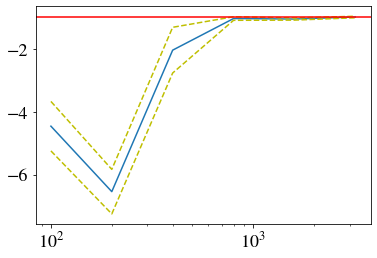

In [32]:
alp_ix = 1
foos = np.array(est_alps)[:, :, alp_ix].mean(axis=1)
bd = 1.96*np.array(est_alps)[:, :, alp_ix].std(axis=1)/np.sqrt(num_rep)
plt.plot(ns, foos)
plt.plot(ns, foos+bd, "y--")
plt.plot(ns, foos-bd, "y--")
plt.axhline(y=data_gen_params.gt_alp[alp_ix], color="red");
plt.xscale("log")

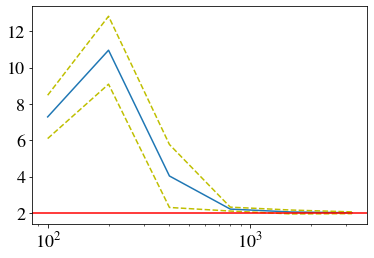

In [33]:
alp_ix = 2
foos = np.array(est_alps)[:, :, alp_ix].mean(axis=1)
bd = 1.96*np.array(est_alps)[:, :, alp_ix].std(axis=1)/np.sqrt(num_rep)
plt.plot(ns, foos)
plt.plot(ns, foos+bd, "y--")
plt.plot(ns, foos-bd, "y--")
plt.axhline(y=data_gen_params.gt_alp[alp_ix], color="red");
plt.xscale("log")